In [1]:
import pandas as pd
import random
import numpy
from numpy.testing import assert_almost_equal
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [101]:
test_doc1 = """Signal transducer and transcription activator that mediates cellular responses to interferons (IFNs), cytokine KITLG/SCF and other cytokines and other growth factors. 
Following type I IFN (IFN-alpha and IFN-beta) binding to cell surface receptors, signaling via protein kinases leads to activation of Jak kinases (TYK2 and JAK1) and to tyrosine phosphorylation of STAT1 and STAT2. 
The phosphorylated STATs dimerize and associate with ISGF3G/IRF-9 to form a complex termed ISGF3 transcription factor, that enters the nucleus (PubMed:28753426). ISGF3 binds to the IFN stimulated response element (ISRE) to activate the transcription of IFN-stimulated genes (ISG), which drive the cell in an antiviral state. In response to type II IFN (IFN-gamma), STAT1 is tyrosine- and serine-phosphorylated (PubMed:26479788). It then forms a homodimer termed IFN-gamma-activated factor (GAF), migrates into the nucleus and binds to the IFN gamma activated sequence (GAS) to drive the expression of the target genes, inducing a cellular antiviral state. Becomes activated in response to KITLG/SCF and KIT signaling. 
May mediate cellular responses to activated FGFR1, FGFR2, FGFR3 and FGFR4"""

In [102]:
from generif2vec.text.util import tokenize
test_tokens = tokenize([test_doc1])

In [103]:
generif_embeddings_file = '/Users/kevin/projects/generif2vec/generif2vec.doc2vec'
model = Doc2Vec.load(generif_embeddings_file)

In [104]:
test_vec = model.infer_vector(test_tokens[0], epochs=20)

In [105]:
gene_labels = list(model.docvecs.doctags.keys())

In [106]:
len(gene_labels)

7704

In [107]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [108]:
%%R
library(GOSemSim);
hsGO <- godata('org.Hs.eg.db', keytype = "SYMBOL", ont = "MF");

R[write to console]: preparing gene to GO mapping data...

R[write to console]: preparing IC data...



In [109]:
%%R -i gene_labels -o dat
#dat <- data.frame(matrix(unlist(gene_labels), nrow=length(gene_labels), byrow=T))
dat <- do.call(rbind.data.frame, gene_labels)
colnames(dat) <- c('gene_symbol')

In [110]:
%%R -o results_mf
scoreGene <- function(gene) {
    result <- geneSim("STAT1", gene, semData=hsGO, measure="Rel", combine="BMA")
    if (is.na(result)) {
        score <- -1.0
    }
    else {
        score <- result$geneSim
    }
    score
}
results_mf <- mapply(scoreGene, dat$gene_symbol)

In [111]:
dfmf = pd.merge(dat.reset_index(drop=True), 
                 pd.Series(results_mf, name='semsim_mf_score'), 
                 left_index=True, 
                 right_index=True
                )

In [112]:
dfmf.loc[dfmf['semsim_mf_score'] == -1.0].shape

(507, 2)

# Merge

In [113]:
dfvec = pd.DataFrame(model.docvecs.most_similar([test_vec], topn=len(gene_labels)), 
                     columns=['gene_symbol', 'doc2vec_score'])

In [114]:
dfscores = dfvec.merge(dfmf)#.merge(dfbp)

In [115]:
dfscores = dfscores.loc[dfscores['semsim_mf_score']>=0]

In [116]:
dfscores.corr()

,doc2vec_score,semsim_mf_score
doc2vec_score,1.000000,0.191833
semsim_mf_score,0.191833,1.000000


In [117]:
# dfscores['max_semsim_score'] = dfscores[['semsim_mf_score', 'semsim_bp_score']].max(axis=1)

In [118]:
dfscores

,gene_symbol,doc2vec_score,semsim_mf_score
0,STAT1,0.659870,0.967
1,STAT2,0.651672,0.692
2,IRF9,0.575327,0.524
3,CSNK1A1,0.567428,0.170
4,IKBKE,0.558950,0.278
...,...,...,...
7698,NSDHL,0.026808,0.000
7699,ADAM23,0.020712,0.276
7701,SLC41A1,0.013098,0.000
7702,NUSAP1,0.012013,0.276


In [119]:
import seaborn as sns
import matplotlib.pyplot as plt

In [120]:
from scipy.stats import pearsonr
pearsonr(dfscores['doc2vec_score'], dfscores['semsim_mf_score'])

(0.1918331233312043, 1.2853493463381866e-60)

In [121]:
dfscores.sort_values(by='semsim_mf_score', ascending=False).head(10)

,gene_symbol,doc2vec_score,semsim_mf_score
6817,TACC2,0.155399,0.997
7349,BRD1,0.122922,0.996
5435,EFHD2,0.207051,0.995
3210,DIAPH3,0.268067,0.995
3461,COBLL1,0.260692,0.995
932,MUC13,0.351670,0.988
6296,CIDEA,0.179059,0.988
1788,DEFA3,0.312001,0.988
3345,DEFA4,0.264060,0.988
2295,GNPTG,0.294467,0.988


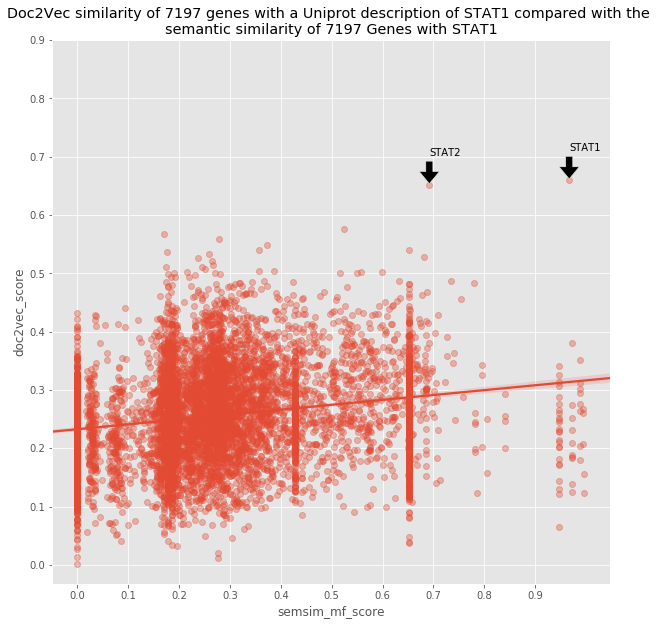

In [122]:
plt.style.use('ggplot');
plt.figure(figsize=(10, 10));
plt.title('Doc2Vec similarity of 7197 genes with a Uniprot description of STAT1 compared with the \nsemantic similarity of 7197 Genes with STAT1');
sns.regplot('semsim_mf_score', 'doc2vec_score', data=dfscores, scatter_kws={'alpha':0.35});
plt.yticks(np.arange(0, 1, 0.1));
plt.xticks(np.arange(0, 1, 0.1));

stat1_xy = dfscores.loc[dfscores['gene_symbol'] == 'STAT1'][['semsim_mf_score', 'doc2vec_score']].values[0]

plt.annotate('STAT1', xy=(stat1_xy[0], stat1_xy[1]), xytext=(stat1_xy[0], stat1_xy[1]+0.05),
             arrowprops=dict(facecolor='black', shrink=0.05, headwidth=20, width=7));

stat2_xy = dfscores.loc[dfscores['gene_symbol'] == 'STAT2'][['semsim_mf_score', 'doc2vec_score']].values[0]
plt.annotate('STAT2', xy=(stat2_xy[0], stat2_xy[1]), xytext=(stat2_xy[0], stat2_xy[1]+0.05),
             arrowprops=dict(facecolor='black', shrink=0.05, headwidth=20, width=7));
